In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/ML大作业/人脸识别")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Tue Jun  9 16:04:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# <center><font size=10>人脸识别</font></center>



# <span id='content'>目录</span>

## [一、课前回顾](#一)

## [二、卷积神经网络之应用--人脸识别](#二)

### [- 1. 人脸识别简介](#二-1)

### [- 2. 人脸识别两大问题：人脸认证、人脸识别](#二-2)

### [- 3. 进行人脸认证的一种简单思路](#二-3)

### [- 4. 使用卷积神经网络进行人脸认证的流程概括](#二-4)

## [三、人脸识别流程详细说明](#三)

### [- 1. 迁移学习](#三-1)

### [- 2. 举例：用VGG16模型进行编码](#三-2)

### [- 3. LFW数据库](#三-3)

### [- 4. 通过比对两张图片的编码进行人脸认证](#三-4)

### [- 5. 阈值的确定](#三-5)

### [- 6. 三元组代价函数--一种在人脸识别领域应用广泛且有效的损失函数](#三-6)

### [- 7. MTCNN](#三-7)

## [四、大作业：班级人脸识别项目](#四)


# <span id='一'>一、课前回顾</span>

上一课中，我们已经开始用卷积神经网络进行图片分类，已经了解了如下知识点：

- convolution：相关概念filter, padding, channel
- batch normalization 批规范化：通过对每一层的输出规范为均值和方差一致的方法，消除了w带来的放大缩小的影响。
- pooling: max vs. average
- 激活函数：softmax, Relu, Sigmoid

# <span id='二'>二、卷积神经网络之应用--人脸识别</span>

卷积神经网络最重要的应用之一是人脸识别，这一课我们就用卷积神经网络来处理人脸图片。


## <span id='二-1'>1. 人脸识别简介</span>
- 定义：
 - 广义的人脸识别实际包括构建人脸识别系统的一系列相关技术，包括人脸图像采集、人脸定位或检测、人脸识别预处理、身份确认以及身份查找等；
 - 而狭义的人脸识别特指通过人脸进行身份确认或者身份查找的技术或系统。
- 人脸识别的一般处理流程：
 - 图像获取：人脸图像通过摄像镜头获取得到；
 - 人脸检测：在图像中标定出人脸的位置和大小，自动估计脸部特征的坐标；
 - 人脸图像预处理：由于原始图像往往受到光照、角度等条件的限制和干扰，故须在图像处理的早期阶段对其进行灰度矫正、噪声过滤等预处理。
   - 常用预处理方法有 ：灰度变化、归一化、直方图均衡、中值滤波等；
 - 人脸特征提取：可通过嵌入向量的方法提取出有助于人脸分类的特征数据；
 - 比对识别：两张人脸图片经一系列操作后可进行对比识别；
 - 输出结果：判断两张人脸图片是否属于同一人。
 
  如下图所示：

<img style = "float:left" src = "辅助图片/人脸识别流程.jpg">

## <span id='二-2'>2. 人脸识别两大问题：人脸认证、人脸识别</span>

#### (1). 人脸识别：
首先拥有多人图像数据库，然后输入一张不在数据库中的人脸图像，目标是判断此人是否在数据库中，是的话并找到对应的那个人。是1：N问题。

注：人脸认证和人脸识别也可统称为人脸识别，本课在不混淆意思的前提下会统称为人脸识别。

#### (2). 人脸认证：
输入人脸图像，并指定数据库中要比对的人，目标是判断两张人脸图像是否属于同一个人，是1：1问题。


#### (3). 二者对比：
|  |  人脸认证   | 人脸识别  |
| :----  |  :----  | :----  |
| 输出  | 认证的信心度  | 最相似的人脸以及信心度 |
| 实现要求  |    在手机配置上就可以实现得很好  | 对于计算和存储的要求更高 |
| 成功要求  | 很低的false positive  | 很低的false positive和false negative |



就二者的难度来说，人脸识别要比人脸认证难得多：

假设一个认证系统的准确率是99%，把这个认证系统应用到有100个人数据库的人脸识别上，犯错的机会就会乘以100。所以如果有一个上百人的数据库，并且想得到一个可接受的人脸识别误差，首先构造的人脸认证系统就需要99.9%，甚至更高的准确率才行。

我们可以考虑首先构造一个人脸认证系统作为基本模块，进行处理之后，再把它应用到人脸识别系统上。


## <span id='二-3'>3. 进行人脸认证的一种简单思路</span>
对于人脸认证，最简单的思路是：
拿到两张人脸图像，直接比较两张图像中所有像素值的差别，取其加和。若该值小于事先确定的阈值，则可以认为他们是同一个人。

>思考：这样做会存在什么问题吗？

答：比对过程会受到非人脸部分的影响，即色彩、亮度、环境等都会使两张的图像的像素值之差不准确。例如，同一个人的照片加个滤镜可能就认不出来了。同时，同一个人不同角度的图片也会在像素值上有天翻地覆的差别，从而影响结果。

>思考：那么能否从图像中剔除这些影响，只找到与人脸外形相关的特征，然后进行比对？

答：对于受到非人脸环境的影响问题，可参照人脸识别处理流程中的预处理步骤，对图片进行预处理；而对于同人不同角度等问题造成的识别精度不够这种情况，则提醒我们要寻求一个更精准识别人脸的方法。

也就是本课的主题：运用卷积神经网络识别人脸。

## <span id='二-4'>4. 使用卷积神经网络进行人脸认证的流程概括</span>

卷积神经网络分别以两张图片作为输入，然后输出这两张图片的编码（即特征向量）。如果你放进同一个人的两张照片，你希望最后输出的两个编码之间的距离很小，如果放进两个长相差别很大的人的照片，就希望距离很大。

所以在人脸认证过程中，需要人为确定一个阈值。如果这两张图片的距离小于某个阈值，那么这时就能预测这两张图片是同一个人，如果距离大于阈值，就能预测这是不同的两个人。

***
>现在让我们开始我们的人脸识别之旅吧！

首先导入本课程所需要的库以及运行所需要的各项准备：
***

In [ ]:
import os
import torchvision.models as models
from PIL import Image, ImageDraw
import datetime
from torch.autograd import Variable
import torch
import cv2
import numpy as np
from facenet_pytorch import MTCNN, extract_face
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### <span id='三'>三、人脸识别流程详细说明</span>

>首先，我们学习如何将人脸图片进行编码。

卷积神经网络（CNN）常用来为人脸图片编码。例如，VGG就是这样一个为图像编码的CNN模型，其效果如下图所示：

<img src = "辅助图片/VGG编码.jpg">


>人脸图片的编码完成后，我们会利用编码来完成一系列功能。这是一个迁移学习过程。

## <span id='三-1'>1. 迁移学习</span>
>吴恩达：“迁移学习将会是继监督学习之后的下一个机器学习商业成功的驱动力。”

- 出现背景：
 - 目前的深度学习只有在拥有充足的标注数据时才能达到很好的准确率。
 - 海量数据下的模型训练需要非常大的算力。普通人：臣妾做不到啊~

- 思想：将旧领域的模型应用在新领域上，从而加快并优化模型的学习效率。

- 具体做法：利用在大数据集上预先训练好的神经网络来初始化网络（而不是随机初始化），然后根据自己的目标任务需求，可选择通过微调等操作对这个神经网络的结构进行改动，并在自己的数据集上进行进一步的训练。

- 核心问题：
 - 如何合理地寻找不同领域之间的相似性，从而利用相似性，将已有模型应用到新的不同的、但有一定关联的领域中。
 - 如何对使用的预训练模型进行适用于自己目标任务的改动。

- 例如：
  在自然语言处理领域中，预训练模型BERT的语义表达效果非常好。输入一句话，BERT可以生成这句话的嵌入向量（即用数字向量的形式来表达这句话），距离相近的向量对应的原句的意思也是相近的。我们在BERT模型的基础上，给这个神经网络再加上一个头部，如加上全连接层来作为分类器，就可以把输入的文本做分类，从而应用到如情感分析等具体任务上。


本课我们使用VGG16模型为例，展示一下图片的编码结果。鼓励同学们在进行大作业的编写时，通过查找和对比效果来选择其他效果更好的模型，并可选择结合迁移学习知识，使模型效果更佳。

## <span id='三-2'>2. 举例：用VGG16模型进行编码</span>

#### 选取两张图片，进行大小调整，使其符合VGG16模型的输入要求

In [ ]:
# 为了能够读写带中文路径的图片，重新定义cv2的读写函数
def cv2_imread(file_path):
    cv_img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), -1)
    return cv_img


def cv2_imwrite(path, img):
    cv2.imencode('.jpg', img)[1].tofile(path)

img1 = cv2_imread("李小强.jpg")
new_img1 = cv2.resize(img1, (224, 224))
cv2_imwrite("preprocessed李小强.jpg", new_img1)

img2 = cv2_imread("张小二.jpg")
new_img2 = cv2.resize(img2, (224, 224))
cv2_imwrite("preprocessed张小二.jpg", new_img2)

#### 将图片格式修改为可以直接输入模型的张量格式，然后调用训练好的VGG模型，输出图片通过模型前后的格式。

In [ ]:
# 定义函数，将图片转成张量格式
def tensor_convert_vgg(img_path):
    img = cv2_imread(img_path)
    batch = img.reshape(1, 3, 224, 224)
    tensor = torch.from_numpy(batch).float().to(device)
    return tensor

img1_name = "preprocessed李小强.jpg"
img2_name = "preprocessed张小二.jpg"


tensor1 = tensor_convert_vgg("preprocessed李小强.jpg")
tensor2 = tensor_convert_vgg("preprocessed张小二.jpg")

vgg = models.vgg16(pretrained=True).eval().to(device)

result1 = vgg(Variable(tensor1))
result2 = vgg(Variable(tensor2))

print("李小强：\n", "  vgg16模型输入大小为: ", list(tensor1.size()),
      "; 输出大小为: ", list(result1.size()))
print("张小二：\n", "  vgg16模型输入大小为: ", list(tensor2.size()),
      "; 输出大小为: ", list(result2.size()))


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



李小强：
   vgg16模型输入大小为:  [1, 3, 224, 224] ; 输出大小为:  [1, 1000]
张小二：
   vgg16模型输入大小为:  [1, 3, 224, 224] ; 输出大小为:  [1, 1000]


若运行结果正确，我们可以看到，通过VGG模型前，两张图像的大小为\[1, 3, 224, 224]，分别对应\[样本数, 图像通道数, 图像高度, 图像宽度]。通过VGG模型后，两张图像变成了两个1000维的特征向量。

#### (4). 注意事项：
同学们在进行实验时，要先明确好自己选择的模型的输入是什么格式，以免出错。

>上述应用的两张图片都是从LFW数据集中选取的。

## <span id='三-3'>3. LFW数据库</span>

LFW (Labeled Faces in the Wild)人脸数据库主要用于研究非受限情况下的人脸识别问题。共含有13000多张人脸图像，其主要来源是互联网。每张图像都被标识出对应的人的名字，大约其中的1680人包含两个以上的人脸。

LFW数据库可用于测试人脸识别的准确率，该数据库随机选择了6000对人脸组成了人脸辨识图片对，其中3000对属于同一人，3000对属于不同的人。测试过程中，LFW数据库随机给出一对图片，询问测试中的系统这两张图片是不是同一个人，系统给出“是”或“否”的答案。通过6000对人脸测试结果的系统答案与真实答案的比值，可以得到系统的人脸识别准确率。

[LFW数据库传送门](http://vis-www.cs.umass.edu/lfw/)
***
>现在我们的第一步已经完成，即已经将图像编好码了。接下来就是要对比两张图片。

## <span id='三-4'>4. 通过比对两张图片的编码进行人脸认证</span>

**实际上，对比两张图片就是要对比图片对应的编码向量的距离（如欧几里得距离），如下图所示。**

<img src = "辅助图片/两人距离.jpg">

>进行人脸认证时，要确定两张图片是否是同一张人脸，需要事先确定一个阈值，当两张图片的距离小于阈值时，模型认为图片是同一张人脸；当距离大于阈值时，认为是不同的人脸。那么，阈值该如何确定呢？

## <span id='三-5'>5. 阈值的确定</span>
加上阈值后，整个人脸识别流程如下图所示：

<img style = "float:left" src = "辅助图片/两人距离有阈值.jpg">

对于阈值的确定没有数学上的计算方法，而通常是通过尝试，根据经验选择。在确定阈值的过程中，往往要事先确定好一个范围，并通过不断地在多个图像组上的测试，来缩小这个范围，最终在错误率最低的那个范围中选取一个值作为最终的阈值。

***


## <span id='三-6'>6. 三元组代价函数--一种在人脸识别领域应用广泛且有效的损失函数</span>

我们本课直接使用了VGG16预训练模型做例，但是用户可以根据自己的需求进行模型选择或者在原模型基础上进行改进。比如在训练过程中，我们可以改为在人脸识别领域效果更好的三元组代价函数（Triplet Loss），然后再通过梯度下降来更新网络中的权重。

#### (1). 三元组是什么：
- 样本组成：三张图片：
 - 靶目标(Anchor)，简写为 $A$.
 - 正例(Positive)，简写为 $P$.
 - 反例(Negative)，简写为 $N$.
- 样本要求：靶目标和正例是同一个人，和反例不是同一个人。
- 目的：在定义了这些包括$A、P、N$图片的数据集后，用梯度下降最小化代价函数，使得$A$和$P$之间的距离很小，而$A$和$N$之间的距离很大。
- 效果：通过改变神经网络中的权重，最终得到一个优秀的特征向量，使得相似的图像在向量空间是相近的，可以借此判断是否是同一个人的人脸。

三元组代价函数的效果图如下：

<img style = "float:left" src = "辅助图片/三元代价函数效果图.jpg">

#### (2). 三元组代价函数（Triplet Loss）的推导：
设图片A的编码为$f(A)$，图片P的编码是$f(P)$，图片N的编码是$f(N)$，我们希望靶目标A和正例图片P的间距小于靶目标和反例图片N的间距，即：

$$\|f(A)-f(P)\|^{2} \leq\|f(A)-f(N)\|^{2}$$

$$\|f(A)-f(P)\|^{2}-\|f(A)-F(N)\|^{2} \leq 0$$

但是这样还不够，比如当 $d(A,P)=0.5$, $d(A,N)=0.51$ 的时候，虽然满足了要求，但是二者之间的距离差很小，这样训练得到的结果不能很好地区分相似的图像，因此为了增强算法的鲁棒性，我们引入一个超参数 $\alpha$，将上述不等式修改为：

$$\|f(A)-f(P)\|^{2}-\|f(A)-f(N)\|^{2} \leq-\alpha$$

$$\|f(A)-f(P)\|^{2}-\|f(A)-F(N)\|^{2}+\alpha \leq 0$$

超参数 $\alpha$ 类似于支持向量机中的margin，目的就是要拼命拉近靶目标和正例之间的距离、拉远靶目标和反例之间的距离。

同时，$\alpha$ 值的选取也是一门学问：过小的话会将所有图像映射到极小区域范围内的向量空间，不能很好地区分；过大的话loss值会很难趋近于零，训练时间会无限延长。

***
综上，三元组代价函数是基于上述三元图片组的，定义为：

$$L(A, P, N)=\max \left(\|f(A)-f(P)\|^{2}-\|f(A)-f(N)\|^{2}+\alpha, 0\right)$$

在代价函数中，取两项中的最大值，我们要尽可能的使 $\|f(A)-f(P)\|^{2}-\|f(A)-f(N)\|^{2}+\alpha$ 这一项为0，或者小于0，这样这组三元组得到的代价值就为0；如果前一项大于0，得到的代价值就会大于0.

整个网络的代价函数就是训练集中每个三元组代价的总和，若共有M个三元组，则整个网络的三元代价函数为：

$$J=\sum_{i=1}^{M} L\left(A^{(i)}, P^{(i)}, N^{(i)}\right)$$

#### (3). 如何选择三元组来构成训练集？

你可能觉得，随机选择是最好的方法。但是实际上，这样的话约束条件 $d(A, P)+\alpha \leq d(A, N)$ 就会很容易实现。因为随机选择的图片，$A$ 和 $N$ 比 $A$ 和 $P$ 差别很大的概率不算小，这样的话网络并不能从中学习到什么。

所以，为了构建一个更有效的数据集，要做的就是尽可能选择难训练的三元组 $A$、 $P$ 和 $N$。 即要想使得所有三元组都满足条件
$d(A, P)+a \leq d(A, N)$ ，应选择最接近的 $d(A, P)$ 和 $d(A, N)$，这样学习算法会竭尽全力使得 $d(A, N)$ 变大，或者使得 $d(A, P)$ 
变小，这样选择可以增加学习算法的计算效率。


>以上代码全是根据数据集中的照片进行操作的，如果提供日常中拍出的照片，进行人脸识别，会出现什么问题呢？

## <span id='三-7'>7. MTCNN</span>

我们知道，数据集中的照片都是经过加工之后的，是专门用来训练或者测试模型的。但是日常拍照并非如此，普通照片中，人的身体和周围环境往往被照进镜头从而导致人脸识别误差增大。

此时，我们需要进行一系列操作，使得机器能够自动截取照片上的人脸，然后再送去编码识别。

**MTCNN就是干这个的。**

MTCNN（多任务卷积神经网络）中的"MT"是指多任务学习(Multi-Task)，同时学习“识别人脸”、“人脸边框回归”、“人脸关键点识别”；"CNN"是指卷积神经网络(Convolutional Neural Network)。MTCNN是由中国科学院提出的用于人脸检测任务的多任务神经网络模型，可进行快速高效的人脸检测。

我们来尝试使用MTCNN，看看它的作用效果。

In [ ]:
mtcnn = MTCNN(keep_all=True)
img = Image.open("test1.jpg")
boxes, probs, points = mtcnn.detect(img, landmarks=True)
img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)
for i, (box, point) in enumerate(zip(boxes, points)):
    draw.rectangle(box.tolist(), width=5)
    for p in point:
        draw.rectangle((p-10).tolist()+(p+10).tolist(), width=10)
    extract_face(img, box, save_path='detect_face_{}.png'.format(i))
img_draw.save('annotated_faces.png')

上面这个代码块使用同级目录下的名为"test1.jpg"的图片作为输入，将经过MTCNN人脸关键点标注后的结果进行可视化之后命名为"annotated_face.png"，保存在同级目录下，将MTCNN的截取结果命名为"detect_face_0.png"，保存在同级目录下。下面进行这三张图片的展示。

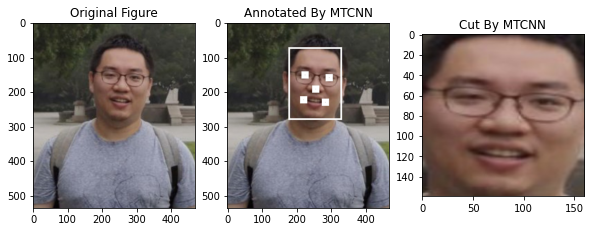

In [ ]:
plt.figure()
plt.subplots_adjust(left=0.125, bottom=0.1, right=1.4, top=0.9,
                wspace=0.2, hspace=0.2)
img = Image.open("test1.jpg")
ax = plt.subplot(1,3,1)
plt.imshow(img)
ax.set_title("Original Figure")

img = Image.open("annotated_faces.png")
ax = plt.subplot(1,3,2)
plt.imshow(img)
ax.set_title("Annotated By MTCNN")

img = Image.open("detect_face_0.png")
ax = plt.subplot(1,3,3)
plt.imshow(img)
ax.set_title("Cut By MTCNN")

plt.show()

由上图我们可以看到，MTCNN可以识别一张图片中的人脸位置所在，同时定位到人脸关键点，包括眼、鼻、嘴。所以使用通过MTCNN截取后的人脸图片，我们可以使人脸识别不再受照片中环境等因素的影响，使得识别精度更高。

有感兴趣的同学可以去[这里](https://blog.csdn.net/qq_36782182/article/details/83624357?depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-1&utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-1)看一下MTCNN的具体架构和工作原理，此处不再多讲。

>现在我们已经基本掌握了人脸识别和认所需的模型运用等知识，下面来进行大作业的编写吧！

### <span id='四'>四、大作业：班级人脸识别项目</span>

满足条件及注意事项：
- 将所给人脸照片文件夹作为班级人脸数据库，其中每人有五张图片。
- test文件下存储的是用来识别或认证的不属于数据库中的照片，每人有一张图片。
- 将人脸识别的代码封装成一个函数，命名为facial_recognition，其输入是当前测试图片的路径，且函数要返回最相似的人的名字。
- 将人脸认证的代码封装成一个函数，命名为facial_verification，其输入是数据库中想要比对的人脸id和当前的测试图片的路径，且函数要根据认证的结果，即返回字符串“True”或字符串“False”。
- 定义人名列表，列表中每个元素是人名字符串（即类似于["张三", "李四"]），列表名为names，评测中用到的id值即为在names列表中的序号（从0开始）。
- 最终考核结果标准是识别的准确率和时间，以及认证的四项标准。

# 自己修改的ResNet

In [ ]:
###################Load pretrained ResNet for face recoginze###########################
import torch
from torch import nn
from torch.nn import functional as F
import requests
from requests.adapters import HTTPAdapter
import os

#Cite codes from https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/inceptionresnetv2.py
#Cite codes from https://github.com/timesler/facenet-pytorch/tree/master/models


class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(256, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(96, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(896, 128, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 128, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(128, 128, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super().__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(1792, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1792, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(192, 192, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = BasicConv2d(256, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

class IResnet(nn.Module):
    """Inception Resnet model with optional loading of pretrained weights.
    """
    def __init__(self, pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None):
        super().__init__()

        # Set simple attributes
        self.pretrained = pretrained
        self.classify = classify
        self.num_classes = num_classes

        if pretrained == 'vggface2':
            tmp_classes = 8631
        elif pretrained is None and self.num_classes is None:
            raise Exception('At least one of "pretrained" or "num_classes" must be specified')
        else:
            tmp_classes = self.num_classes


        # Define layers
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)
        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
        )
        self.block8 = Block8(noReLU=True)
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_prob)
        self.last_linear = nn.Linear(1792, 512, bias=False)
        self.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)
        self.logits = nn.Linear(512, tmp_classes)

        if pretrained is not None:
            load_weights(self, pretrained)

        if self.num_classes is not None:
            self.logits = nn.Linear(512, self.num_classes)

        self.device = torch.device('cpu')
        if device is not None:
            self.device = device
            self.to(device)

    def forward(self, x):
        """Calculate logits given a batch of input image tensors.
        Arguments:
            x {torch.tensor} -- Batch of image tensors representing faces.
        Returns:
            torch.tensor -- Batch of embedding vectors or multinomial logits.
        """
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        x = self.last_linear(x.view(x.shape[0], -1))
        x = self.last_bn(x)
        if self.classify:
            x = self.logits(x)
        else:
            x = F.normalize(x, p=2, dim=1)
        return x


def load_weights(mdl, name):
    """
    load weights form checkpoints
    """
    if name == 'vggface2':
      state_dict = {}
      try:
        state_dict.update(torch.load('checkpoints/vggface2_G5aNV2VSMn.pt'))#先存weight
        state_dict.update(torch.load('checkpoints/vggface2_DG3kwML46X.pt'))#再存dict
        mdl.load_state_dict(state_dict)
      except:
        raise RuntimeError('Please download vggface2')
    else:
        raise ValueError('Please use "vggface2"')
##############################Model Ends, Begin Training##########################
#Cite codes from https://github.com/timesler/facenet-pytorch/blob/master/models/utils/training.py
import torch
import numpy as np
import time


class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')


class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.
    
    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)


def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()


def run_epoch(
    model, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):
    """Train or evaluate over a data epoch.
    
    Arguments:
        model {torch.nn.Module} -- Pytorch model.
        loss_fn {callable} -- A function to compute (scalar) loss.
        loader {torch.utils.data.DataLoader} -- A pytorch data loader.
    
    Keyword Arguments:
        optimizer {torch.optim.Optimizer} -- A pytorch optimizer.
        scheduler {torch.optim.lr_scheduler._LRScheduler} -- LR scheduler (default: {None})
        batch_metrics {dict} -- Dictionary of metric functions to call on each batch. The default
            is a simple timer. A progressive average of these metrics, along with the average
            loss, is printed every batch. (default: {{'time': iter_timer()}})
        show_running {bool} -- Whether or not to print losses and metrics for the current batch
            or rolling averages. (default: {False})
        device {str or torch.device} -- Device for pytorch to use. (default: {'cpu'})
        writer {torch.utils.tensorboard.SummaryWriter} -- Tensorboard SummaryWriter. (default: {None})
    
    Returns:
        tuple(torch.Tensor, dict) -- A tuple of the average loss and a dictionary of average
            metric values across the epoch.
    """
    
    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}

    for i_batch, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss_batch = loss_fn(y_pred, y)

        if model.training:
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

        metrics_batch = {}
        for metric_name, metric_fn in batch_metrics.items():
            metrics_batch[metric_name] = metric_fn(y_pred, y).detach().cpu()
            metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
            
        if writer is not None and model.training:
            if writer.iteration % writer.interval == 0:
                writer.add_scalars('loss', {mode: loss_batch.detach().cpu()}, writer.iteration)
                for metric_name, metric_batch in metrics_batch.items():
                    writer.add_scalars(metric_name, {mode: metric_batch}, writer.iteration)
            writer.iteration += 1
        
        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch
        if show_running:
            logger(loss, metrics, i_batch)
        else:
            logger(loss_batch, metrics_batch, i_batch)
    
    if model.training and scheduler is not None:
        scheduler.step()

    loss = loss / (i_batch + 1)
    metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}
            
    if writer is not None and not model.training:
        writer.add_scalars('loss', {mode: loss.detach()}, writer.iteration)
        for metric_name, metric in metrics.items():
            writer.add_scalars(metric_name, {mode: metric})

    return loss, metrics

##################################################################################

In [ ]:
################################Modify the pre-trained model#######################
#Pretrained modle has been saved at checkpoints/
#Please download at https://drive.google.com/drive/folders/13jYkrdKuqfBWArm1zasevMIZnLLM_c4_?usp=sharing
#Or Baidu Drive Link: 
resnet = IResnet(
    classify=True,
    pretrained='vggface2',
    num_classes=104
).to(device)
layer_list = list(resnet.children())[-5:] # all final layers

In [ ]:
print(layer_list)

[AdaptiveAvgPool2d(output_size=1), Dropout(p=0.6, inplace=False), Linear(in_features=1792, out_features=512, bias=False), BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=512, out_features=104, bias=True)]


In [ ]:
model_modified = nn.Sequential(*list(resnet.children())[:-5])# without the final linear, pooling, batchnorm, and sigmoid layers.

In [ ]:
class Flatten(nn.Module):
  '''
  flatten层 压平特征
  '''
  def __init__(self):
    super(Flatten, self).__init__()
        
  def forward(self, x):
    x = x.view(x.size(0), -1)
    return x
class normalize(nn.Module):
  '''
  Normalize层 近似独立同分布
  '''
  def __init__(self):
    super(normalize, self).__init__()
        
  def forward(self, x):
    x = F.normalize(x, p=2, dim=1)
    return x

In [ ]:
#将模型后五层更改成如下
model_modified.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_modified.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_modified.logits = nn.Linear(layer_list[4].in_features,104)
model_modified.softmax = nn.Softmax(dim=1)
model_modified = model_modified.to(device)

In [ ]:
layer_list = list(model_modified.children())[-5:] #查看修改后的 final layers

In [ ]:
print(layer_list)

[Block8(
  (branch0): BasicConv2d(
    (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (branch1): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (conv2d): Conv2d(384, 1792, kernel_size=(1, 1), st

In [ ]:
#################################START OF YOUR HOMEWORK#################################
'''
构建数据集

NOTICE:由于涉及到无法恢复的文件操作，请下载我已清洗好并设计好标准文件结构的数据：

下载清洗好的训练数据集https://drive.google.com/uc?export=download&id=1W_3yT-YS-hgsgwODeQRFWslcR6MAsduL
下载清洗好的测试数据集https://drive.google.com/uc?export=download&id=1z1NY4bIEiYj-KJeSLGie7-MNXITRnbdZ

并使用 ! unzip -O CP936 filename.zip解压，防止编码被linux系统错误解析

网络原因可以使用Baidu Drive Link:
训练数据：
链接：https://pan.baidu.com/s/1ZzNexZOu6SSahEiUdvZbdw 
提取码：8gg0

测试数据
链接：https://pan.baidu.com/s/1kw8_kAnaJOlEDa01C_D-9w 
提取码：jxmq 

如果您希望使用新的数据进行测试，请参考测试部分的注释
'''

'''
批量修改文件夹名字，删除学号，使得姓名符合ImageFloder的读取格式
def replaceDirName(rootDir):
  #修改rootDir路径下的文件夹名
    num = 0
    dirs = os.listdir(rootDir)
    for dir in dirs:
        print('oldname is:' + dir)                # 输出老的名字
        num = num +1
        try:
          temp = dir.split('_')[1]
        except IndexError:
          try:
            temp=dir.split('-')[1]
          except:
            print("This is not structure", dir)
            continue
        except:
          print("This is not structure", dir)
          continue
        print('new name:',temp)
        oldname = os.path.join(rootDir, dir)      # 老文件夹的名字
        newname = os.path.join(rootDir, temp)     # 新文件夹的名字
        os.rename(oldname, newname)        #替换
replaceDirName('align_data')
'''

'''
使用MTCNN清洗原始数据，不能识别人脸的保留
names=[]
ab_path="数据库图片"
img_path = "data"
k=0
for item in os.listdir(ab_path):
    names.append(item)
    try:
      os.makedirs(img_path+"/"+str(item))
    except FileExistsError:
      continue
    k=k+1
    for i in os.listdir(ab_path+'/'+str(item)):
        mtcnn = MTCNN(keep_all=True)
        try:
            img = Image.open(ab_path+'/'+str(item)+'/'+i).convert('RGB')
            boxes, probs, points = mtcnn.detect(img, landmarks=True)
            img_draw = img.copy()
            draw = ImageDraw.Draw(img_draw)
            for j, (box, point) in enumerate(zip(boxes, points)): 
                draw.rectangle(box.tolist(), width=5)
                for p in point:
                    draw.rectangle((p-10).tolist()+(p+10).tolist(), width=10)
                extract_face(img, box, save_path=img_path+'/'+str(item)+'/'+i.format(0).split('_')[-1])
        except:
            img=Image.open(ab_path+'/'+str(item)+'/'+i).convert('RGB')
            print(img_path+'/'+str(item))
            img.save(img_path+'/'+str(item)+'/'+i.split('_')[-1])
        # print(i)
    print(names)
'''

'''



'''
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np


#均一化
# 对加载的图像作归一化处理， 并裁剪为[160x160x3]大小的图像
data_transforms = {
    'align_data': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.RandomRotation(5,resample = False,expand =False,center = None,fill = None ),#随机旋转
        transforms.RandomHorizontalFlip(),#随机颠倒
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'align_test': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}

'''
data_dir = ''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['align_data','align_test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['align_data','align_test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['align_data','align_test']}
class_names = image_datasets['align_data'].classes
#print(class_names)#打印所有class（中文非序号）
'''


#初始化超参数
batch_size=256
epochs = 32
workers = 0 if os.name == 'nt' else 8
optimizer = optim.Adam(model_modified.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

#构建数据集

data_transforms = {
    'align_data': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.RandomRotation(5,resample = False,expand =False,center = None,fill = None ),#随机旋转
        transforms.RandomHorizontalFlip(),#随机颠倒
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'align_test': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}

#Trian set
data_dir='align_data'
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['align_data'])
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:]
train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)

#Test set
test_dir='align_test'
testset = datasets.ImageFolder(test_dir, transform=data_transforms['align_test'])
test_img_inds = np.arange(len(testset))
np.random.shuffle(test_img_inds)
test_inds = img_inds[:]
test_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=16,
    sampler=SubsetRandomSampler(test_inds)
)

#训练准备
class_names = testset.classes
loss_fn = torch.nn.CrossEntropyLoss()
#三元组损失函数
#loss_fn=torch.nn.TripletMarginLoss(margin=1.0, p=2.0, eps=1e-06, swap=False, size_average=None, reduce=None, reduction='mean')
metrics = {
    'fps': BatchTimer(),
    'acc': accuracy
}

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
model_modified.eval()
run_epoch(
    model_modified, loss_fn, test_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model_modified.train()
    run_epoch(
        model_modified, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model_modified.eval()
    run_epoch(
        model_modified, loss_fn, test_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()

#################################END OF YOUR HOMEWORK#################################



Initial
----------
Valid |    33/33   | loss:    4.6444 | fps:  167.8628 | acc:    0.0038   

Epoch 1/32
----------
Train |     3/3    | loss:    4.6439 | fps:   64.1684 | acc:    0.0919   
Valid |    33/33   | loss:    4.6442 | fps:  206.4585 | acc:    0.0441   

Epoch 2/32
----------
Train |     3/3    | loss:    4.6427 | fps:   65.8216 | acc:    0.1708   
Valid |    33/33   | loss:    4.6435 | fps:  195.6823 | acc:    0.0871   

Epoch 3/32
----------
Train |     3/3    | loss:    4.6422 | fps:   66.2229 | acc:    0.3166   
Valid |    33/33   | loss:    4.6441 | fps:  206.4913 | acc:    0.0095   

Epoch 4/32
----------
Train |     3/3    | loss:    4.6413 | fps:   65.3118 | acc:    0.5897   
Valid |    33/33   | loss:    4.6438 | fps:  198.3568 | acc:    0.0265   

Epoch 5/32
----------
Train |     3/3    | loss:    4.6412 | fps:   67.2802 | acc:    0.5301   
Valid |    33/33   | loss:    4.6421 | fps:  195.1685 | acc:    0.2581   

Epoch 6/32
----------
Train |     3/3    | loss: 

# FaceNet提供的ResNet Demo

In [ ]:
#################################START OF YOUR HOMEWORK#################################
'''
构建数据集

NOTICE:由于涉及到无法恢复的文件操作，请下载我已清洗好并设计好标准文件结构的数据：

下载清洗好的训练数据集https://drive.google.com/uc?export=download&id=1W_3yT-YS-hgsgwODeQRFWslcR6MAsduL
下载清洗好的测试数据集https://drive.google.com/uc?export=download&id=1z1NY4bIEiYj-KJeSLGie7-MNXITRnbdZ

并使用 ! unzip -O CP936 filename.zip解压，防止编码被linux系统错误解析

网络原因可以使用Baidu Drive Link:
训练数据：
链接：https://pan.baidu.com/s/1ZzNexZOu6SSahEiUdvZbdw 
提取码：8gg0

测试数据
链接：https://pan.baidu.com/s/1kw8_kAnaJOlEDa01C_D-9w 
提取码：jxmq 

如果您希望使用新的数据进行测试，请参考测试部分编写的相关函数，帮助您使用新的数据输入模型

'''

'''
批量修改文件夹名字，删除学号，使得姓名符合ImageFloder的读取格式
def replaceDirName(rootDir):
  #修改rootDir路径下的文件夹名,去掉学号保留姓名
    num = 0
    dirs = os.listdir(rootDir)
    for dir in dirs:
        print('oldname is:' + dir)# 输出老的名字
        num = num +1
        try:
          temp = dir.split('_')[1]
        except IndexError:
          try:
            temp=dir.split('-')[1]
          except:
            print("This is not structure", dir)
            continue
        except:
          print("This is not structure", dir)
          continue
        print('new name:',temp)
        oldname = os.path.join(rootDir, dir)# 老文件夹的名字
        newname = os.path.join(rootDir, temp)# 新文件夹的名字
        os.rename(oldname, newname)#替换
replaceDirName('align_data')
'''

'''
使用MTCNN清洗原始数据，不能识别人脸的保留
names=[]
ab_path="数据库图片"
img_path = "data"
k=0
for item in os.listdir(ab_path):
    names.append(item)
    try:
      os.makedirs(img_path+"/"+str(item))
    except FileExistsError:
      continue
    k=k+1
    for i in os.listdir(ab_path+'/'+str(item)):
        mtcnn = MTCNN(keep_all=True)
        try:
            img = Image.open(ab_path+'/'+str(item)+'/'+i).convert('RGB')
            boxes, probs, points = mtcnn.detect(img, landmarks=True)
            img_draw = img.copy()
            draw = ImageDraw.Draw(img_draw)
            for j, (box, point) in enumerate(zip(boxes, points)): 
                draw.rectangle(box.tolist(), width=5)
                for p in point:
                    draw.rectangle((p-10).tolist()+(p+10).tolist(), width=10)
                extract_face(img, box, save_path=img_path+'/'+str(item)+'/'+i.format(0).split('_')[-1])
        except:
            img=Image.open(ab_path+'/'+str(item)+'/'+i).convert('RGB')
            print(img_path+'/'+str(item))
            img.save(img_path+'/'+str(item)+'/'+i.split('_')[-1])
        # print(i)
    print(names)

'''

'''



'''
#os.chdir('../')


from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np


#均一化
# 对加载的图像作归一化处理， 并裁剪为[160x160x3]大小的图像
data_transforms = {
    'align_data': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.RandomRotation(5,resample = False,expand =False,center = None,fill = None ),#随机旋转
        transforms.RandomHorizontalFlip(),#随机颠倒
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'align_test': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}

'''
data_dir = ''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['align_data','align_test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['align_data','align_test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['align_data','align_test']}
class_names = image_datasets['align_data'].classes
#print(class_names)#打印所有class（中文非序号）
'''
#移动到data文件夹所在的地址
#os.chdir('gdrive/My Drive/ML大作业/人脸识别')

#加载预训练集
resnet = IResnet(
    classify=True,
    pretrained='vggface2',
    num_classes=104
).to(device)


#初始化超参数
batch_size=128
epochs = 32
workers = 0 if os.name == 'nt' else 8
#optimizer = optim.Adam(resnet.parameters(), lr=0.001)
optimizer=torch.optim.RMSprop(resnet.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
scheduler = MultiStepLR(optimizer, [5, 10])

#构建数据集

data_transforms = {
    'align_data': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.RandomRotation(5,resample = False,expand =False,center = None,fill = None ),#随机旋转
        transforms.RandomHorizontalFlip(),#随机颠倒
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'align_test': transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}

#Trian set
data_dir='align_data'
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['align_data'])
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:]
train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)

#Test set
test_dir='align_test'
testset = datasets.ImageFolder(test_dir, transform=data_transforms['align_test'])
test_img_inds = np.arange(len(testset))
np.random.shuffle(test_img_inds)
test_inds = img_inds[:]
test_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=16,
    sampler=SubsetRandomSampler(test_inds)
)

#训练准备
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': BatchTimer(),
    'acc': accuracy
}

writer = SummaryWriter('log_RMS_2')
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
run_epoch(
    resnet, loss_fn, test_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    run_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    run_epoch(
        resnet, loss_fn, test_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()

#################################END OF YOUR HOMEWORK#################################



Initial
----------
Valid |    33/33   | loss:    4.8098 | fps:  192.9189 | acc:    0.0119   

Epoch 1/32
----------
Train |     5/5    | loss:    5.3373 | fps:   65.8549 | acc:    0.0063   
Valid |    33/33   | loss: 3550271242240.0000 | fps:  208.2839 | acc:    0.0095   

Epoch 2/32
----------
Train |     5/5    | loss:    5.4778 | fps:   78.8366 | acc:    0.0094   
Valid |    33/33   | loss: 1812057.8750 | fps:  196.8832 | acc:    0.0095   

Epoch 3/32
----------
Train |     5/5    | loss:    5.4334 | fps:   79.7666 | acc:    0.0188   
Valid |    33/33   | loss: 23231.4570 | fps:  198.1673 | acc:    0.0170   

Epoch 4/32
----------
Train |     5/5    | loss:    5.0965 | fps:   78.9676 | acc:    0.0219   
Valid |    33/33   | loss:  126.5259 | fps:  204.2267 | acc:    0.0189   

Epoch 5/32
----------
Train |     5/5    | loss:    5.1065 | fps:   78.4262 | acc:    0.0188   
Valid |    33/33   | loss:    4.5899 | fps:  204.5384 | acc:    0.0189   

Epoch 6/32
----------
Train |     5/

In [ ]:
# 模型保存
torch.save(resnet,'24_epoch_128bz_MODIFIED_TEST82ACC.pb')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type IResnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BasicConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Block35. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Mixed_6a. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.

# 模型测试

In [ ]:
# 加载模型
import os
import torchvision.models as models
from PIL import Image, ImageDraw
import datetime
from torch.autograd import Variable
import torch
import cv2
import numpy as np
from facenet_pytorch import MTCNN, extract_face
import matplotlib.pyplot as plt
device='cpu'
from mybaseclass import *
model=torch.load('24_epoch_128bz_MODIFIED_TEST86ACC.pb',map_location=device)#读取模型
model.eval()

ModuleNotFoundError: ignored

In [ ]:
#为保证模型输出姓名与训练时姓名相同，请使用以下的class_names
class_names=['丁自民',
 '丁自超',
 '何洋龙',
 '佘瑾南',
 '刘漪琛',
 '卢正轩',
 '卢甲浩',
 '司翀杰',
 '吉中旭',
 '吴亦珂',
 '周之遥',
 '周吾君',
 '周圣阳',
 '唐云龙',
 '唐伟',
 '姚杳',
 '孔译轮',
 '孙诚',
 '尹行健',
 '尹鑫龙',
 '岳元浩',
 '庄祎',
 '廖滔',
 '张博宇',
 '张政',
 '张文杰',
 '张欣然',
 '张淼森',
 '张硕',
 '张立创',
 '张雨',
 '张骥',
 '徐子轩',
 '徐昱玮',
 '徐浩卿',
 '徐逸飞',
 '戴恒洁',
 '方大政',
 '曹思辰',
 '曾家俊',
 '朱佳涛',
 '朱斌',
 '朱浩鹏',
 '李孟泽',
 '李春澍',
 '李浩天',
 '李浩瑞',
 '李璟宸',
 '李翔宇',
 '李辰浩',
 '杜宇涵',
 '杜熙源',
 '林欣',
 '栾岱洋',
 '武逸仙',
 '沈书杨',
 '沈毅',
 '沈飞鸿',
 '游家伟',
 '王一名',
 '王倩',
 '王士一',
 '王屹之',
 '王明扬',
 '王明灏',
 '王昕彤',
 '王立远',
 '王行健',
 '王贵涛',
 '王靖婷',
 '白劭宸',
 '盛憬昊',
 '石知一',
 '祁丁然',
 '祁畅',
 '罗琦晴',
 '羊宇培',
 '胡艺凡',
 '蒋林煊',
 '薛翔天',
 '赵基藤',
 '赵琦',
 '边浩文',
 '邵一展',
 '邵彤',
 '邹家馨',
 '郁航远',
 '钟倩如',
 '闻浩',
 '陈品多',
 '陈嘉源',
 '陈文丽',
 '陈翼张',
 '陈耀龙',
 '陈耿',
 '陈震寰',
 '陶特',
 '高奕辰',
 '高成睿',
 '高捷',
 '鲁瀚洋',
 '黄一凡',
 '黄华程',
 '黄腾']

In [ ]:
from PIL import Image
import torchvision.transforms as T
from torchvision import transforms
from torch.autograd import Variable as V
import torch 
trans=T.Compose([ transforms.Scale(160),
            transforms.CenterCrop(160),
            transforms.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
def facial_recognition(path):
  '''
  人脸识别函数，读入path的照片，抓取人脸，模型输出判断结果
  大作业数据库中含有四通道图像，MTCNN无法检测故将跳过，请使用截屏功能进行修改
  path：原始图像路径
  '''
  img1=Image.open(path)
  try:
    mtcnn(img1,save_path='temp.png')
  except:
    #print("This image is 4-dimision, please modify it by screenshot:", path)
    #print("And this step is skipped")#无法识别四通道，即跳过
    return (path.split('/')[1].split('.')[0])
  img2=Image.open('temp.png')
  img3=trans(img2)
  a=[]
  a.append(img3)
  aligned=torch.stack(a).to(device)
  aligned=aligned.reshape(1,3,160,160)
  outputs=model(aligned)
  c,predicted=torch.max(outputs,1)
  name=class_names[predicted.detach().cpu().item()]
  return name

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [ ]:
# 人脸识别评测代码    
from PIL import Image
mtcnn = MTCNN(image_size=160, 
        margin=0,
        min_face_size=60,
        thresholds=[0.6,0.7,0.7],
        factor=0.709,post_process=True,device=device)
names=class_names

test_transform=T.Compose([ transforms.Scale(160),
            transforms.CenterCrop(160),
            transforms.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])



def facial_verification(i,path):
  '''
  人脸认证函数，对比模型输出结果和认证姓名是否匹配
  若输入为4通道图像，则MTCNN无法抓取，请使用屏幕截图进行修正
  i:认证姓名的下标
  path：原始测试图像路径
  '''
  img1=Image.open(path)
  try:
    mtcnn(img1,save_path='temp.png')
  except:
    #print("This image is 4-dimision, please modify it by screenshot:", path)
    #print("This step is skipped")
    p=class_names.index(path.split('/')[1].split('.')[0])
    if p==i:
      return "True"
    else:
      return "False"
  img2=Image.open('temp.png')
  img3=trans(img2)
  img3=(img3).to(device)
  aligned=img3.reshape(1,3,160,160)
  img_tensor=Variable(aligned.cuda())
  if device != 'cpu':
    img_tensor=img_tensor.cuda()
  model.eval()
  with torch.no_grad():
    output=model(img_tensor)
  _,pred_id=torch.max(output.data,1)
  if device != 'cpu':
    torch.cuda.empty_cache()
  if pred_id.item()==i:
    return "True"
  else:
    return "False"

starttime = datetime.datetime.now()
right = 0
wrong = 0

for item in os.listdir("test"):
    test_path = "test/" + item
    if facial_recognition(test_path) == item.split('.')[0]:
        right += 1
    else:
        wrong += 1

accuracy = right / (right+wrong)
endtime = datetime.datetime.now()

print("人脸识别的考察结果：")
print("人脸识别的准确率是:", accuracy)
print("整个人脸识别的运行时间是：", (endtime-starttime).seconds, "s")

# 人脸认证评测代码

tp = 0
tn = 0
fp = 0
fn = 0

for name in names:
    test_path = "test/" + name + ".jpg"
    #请检查照片是否以.jpg结尾，如大作业数据库中，以下四名同学以.JPG结尾
    #若均以.JPG结尾请注释下面两行代码
    if name=="佘瑾南" or name=="曹思辰" or name=="庄祎" or name=="王明灏":
      test_path = "test/" + name + ".JPG"
    for id in range(len(names)):
        result = facial_verification(id, test_path)
        if name == names[id] and result == "True":
            tp +=1
        elif name == names[id] and result == "False":
            fn += 1
        elif name != names[id] and result == "False":
            tn += 1
        else:
            fp += 1

print("人脸认证的考察结果:")
print("精度:", tp/(tp+fp))
print("回归率:", tp/(tp+fn))
print("特异性:", tn/(tn+fp))
print("F1值:", 2*tp/(2*tp+fp+fn))


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


人脸识别的考察结果：
人脸识别的准确率是: 0.7884615384615384
整个人脸识别的运行时间是： 38 s
人脸认证的考察结果:
精度: 0.875
回归率: 0.875
特异性: 0.9987864077669902
F1值: 0.875


# 摄像头功能

In [ ]:
mtcnn = MTCNN(image_size=160, 
        margin=0,
        min_face_size=60,
        thresholds=[0.6,0.7,0.7],
        factor=0.709,post_process=True,device=device)
import cv2
import numpy as np
import os
import sys

mtcnn = MTCNN(image_size=160, 
        margin=0,
        min_face_size=60,
        thresholds=[0.6,0.7,0.7],
        factor=0.709,post_process=True,device=device)

def mtcnn_cut(img_path, save_path):
    img = Image.open(img_path)
    # 应用MTCNN对图片进行检测截取，并保存到指定路径下。
    mtcnn(img, save_path=save_path)
    
def test_camera():
    cap = cv2.VideoCapture(0)
    while(1):
        ret, frame = cap.read()
        cv2.imshow("capture", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2_imwrite("用户拍照上传图片.jpg", frame)
            break
    cap.release()
    cv2.destroyAllWindows()
    mtcnn_cut("用户拍照上传图片.jpg", "用户拍照上传图片.jpg")



choice = input("请输入想要的服务序号：A.人脸识别； B.人脸认证")

if choice == 'A' or choice == 'a':
    test_choice = input("请选择要测试的人脸图片获得途径: A.拍照； B.输入路径")
    if test_choice == 'A' or test_choice == 'a':
        test_camera()
        test_path = "用户拍照上传图片.jpg"

    elif test_choice == 'B' or test_choice == 'b':
        test_path = input("请输入要测试的人脸图片路径：")

        # 测试该test_path下是否存在图片
        img = cv2_imread(test_path)
        if img is None:
            print("该路径下不存在图片！终止程序")
            sys.exit(0)

        mtcnn_cut(test_path, test_path)

    else:
        print("指令不存在！")
        sys.exit(0)

    print(facial_recognition(test_path))  # 进行人脸识别

elif choice == 'B' or choice == 'b':
    test_choice = input("请选择要测试的人脸图片获得途径：A.拍照; B.输入路径")
    if test_choice == 'A' or test_choice == 'a':
        test_camera()
        test_path = "用户拍照上传图片.jpg"

    elif test_choice == 'B' or test_choice == 'b':
        test_path = input("请输入要测试的人脸路径：")
        # 测试该test_path下是否存在图片
        img = cv2_imread(test_path)
        if img is None:
            print("该路径下不存在图片！终止程序")
            sys.exit(0)
        mtcnn_cut(test_path, "test_mtcnn.jpg")  

    else:
        print("指令不存在！")
        sys.exit(0)

    # 便于用户提供想要测试的图片id号
    print("数据库中人脸图片及其序号为：")
    for i, name in enumerate(names):
        print(i, " ", name)

    id = input("请输入想要比对的人脸序号")
    print(facial_verification(int(id), test_path))  # 进行人脸认证